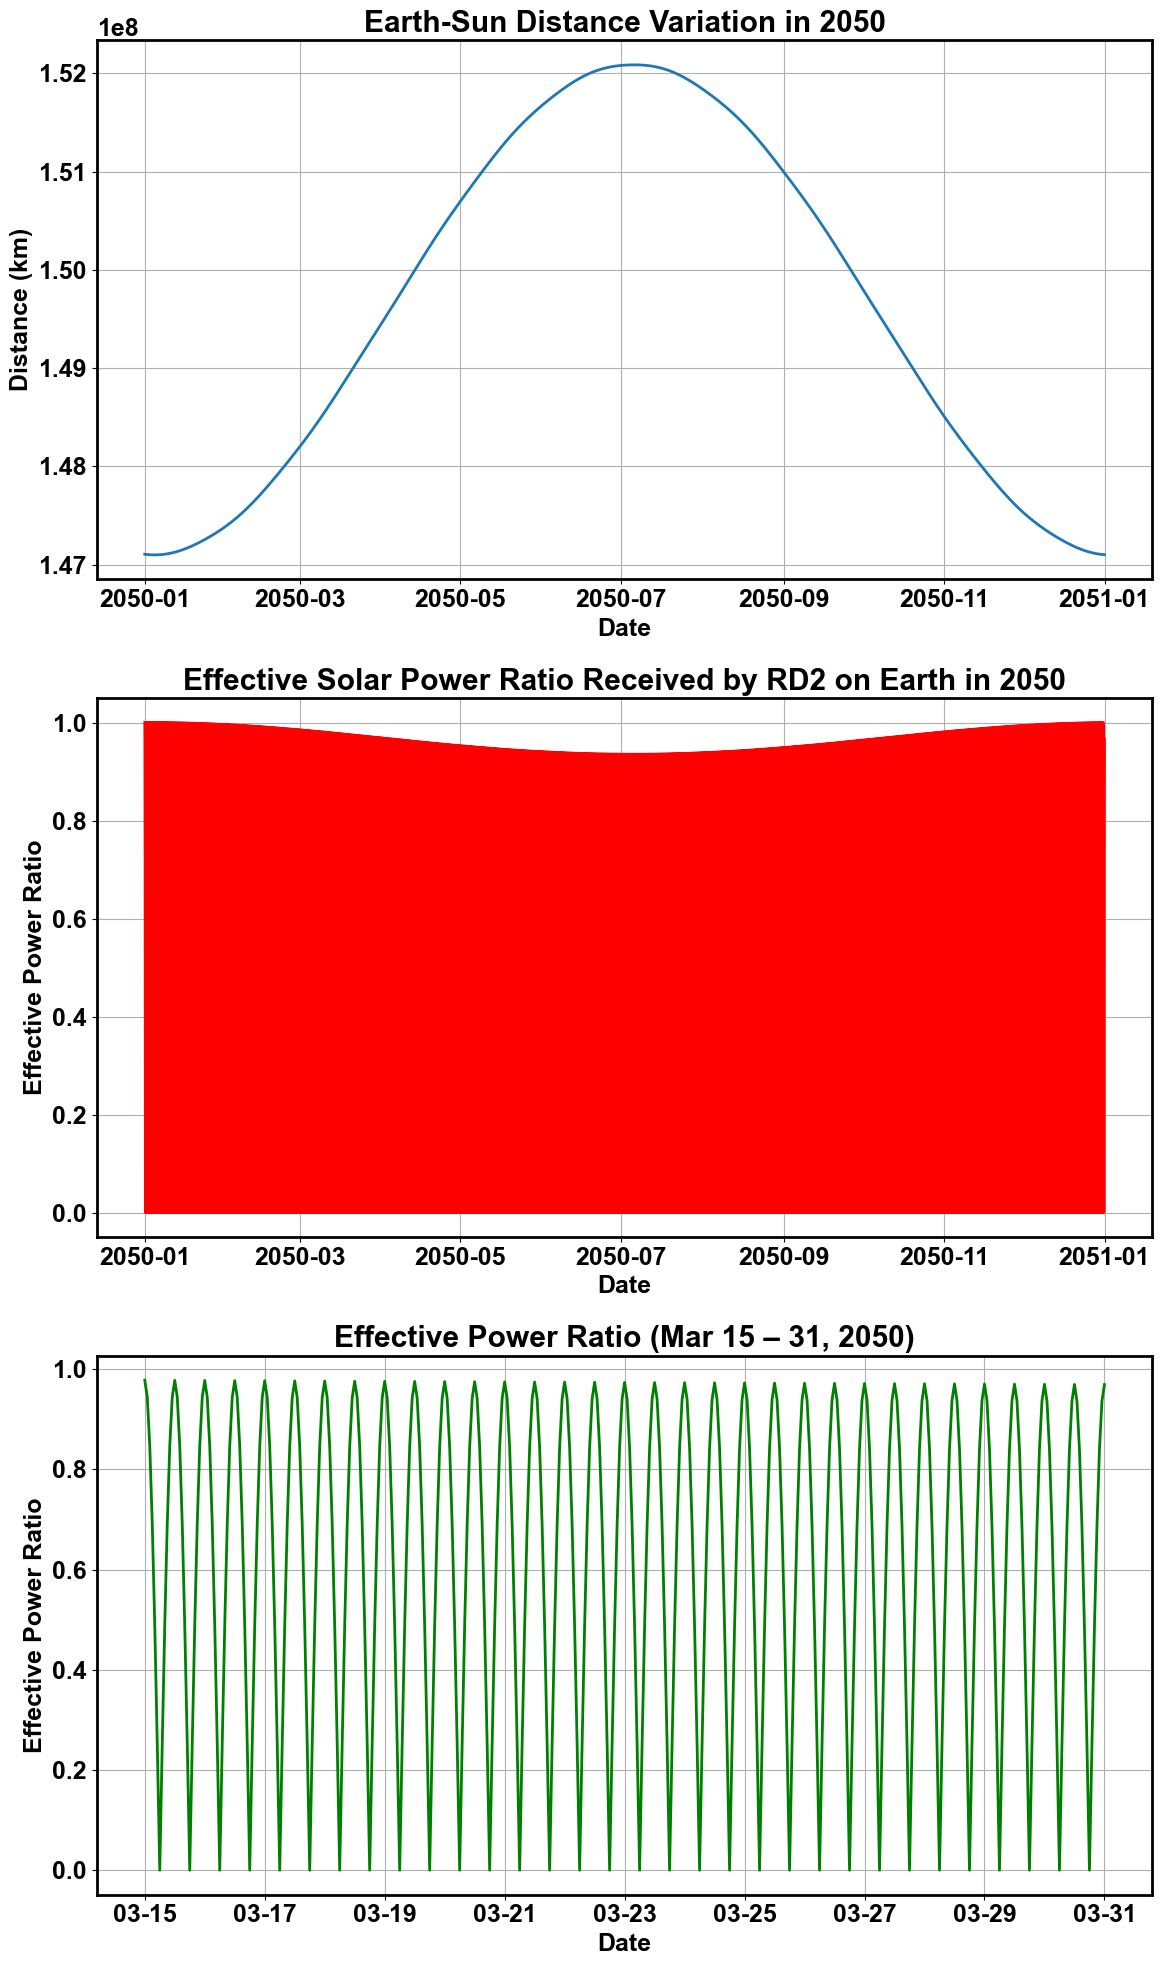

In [1]:
from skyfield.api import load  # Import Skyfield library to load astronomical data
import pandas as pd  
import matplotlib.pyplot as plt  
import numpy as np  
import xarray as xr  

# Load astronomical data and setup celestial bodies
ts = load.timescale()  # Load time scale for astronomical calculations
eph = load('de421.bsp')  # Load DE421 ephemeris file containing positions of celestial bodies
earth = eph['earth'] 
sun = eph['sun'] 

# Generate a time series for every hour in the year 2020
time = pd.date_range(start="2050-01-01", end="2050-12-31 23:00", freq='h') 

# Initialize list to store Earth-Sun distances in kilometers
distance_km = []

# Compute Earth-Sun distance at each hourly timestamp
for single_time in time:  
    t = ts.utc(single_time.year, single_time.month, single_time.day, single_time.hour) 
    earth_at = earth.at(t)  
    distance = earth_at.observe(sun).distance().km  
    distance_km.append(distance)  

distance_data = pd.DataFrame({
    'Date': time, 
    'Distance (km)': distance_km
})

# Calculate the solar power density received at different Earth-Sun distances
solar_constant = 1367.5  # Solar constant in W/m² at 1 AU (astronomical unit)

# Apply a cosine-based seasonal correction factor and inverse square law for solar radiation
power_density = [
    solar_constant * abs(np.cos(t.hour * np.pi / 12)) * (1 / (distance / 1.496e8))**2 
    for t, distance in zip(time, distance_km)
] 

# Define the area of the solar panels in square meters
solar_panel_area = 19 * 1e6 
scaling_factor = 1

# Compute total power received by the solar panels in megawatts (MW)
received_power = [pd * solar_panel_area / scaling_factor / 1e6 for pd in power_density]  # Convert W to MW

# Define power transmission and conversion efficiency factors along the SBSP chain
solar_cell_efficiency = 0.35  
dc_to_dc_efficiency = 0.9  
dc_to_rf_efficiency = 0.7 
antenna_efficiency = 0.9 
atmospheric_transmission_efficiency = 0.98  
beam_collection_efficiency = 0.95  
receiver_antenna_efficiency = 0.78  
ground_dc_to_dc_efficiency = 0.9  

# Calculate effective power in MW by applying all efficiency losses across the transmission chain
effective_power = [
    rp * solar_cell_efficiency * dc_to_dc_efficiency * dc_to_rf_efficiency * antenna_efficiency *
    atmospheric_transmission_efficiency * beam_collection_efficiency * receiver_antenna_efficiency *
    ground_dc_to_dc_efficiency for rp in received_power
]

# Convert the list of effective power values to a pandas Series
effective_power_series = pd.Series(effective_power)

# Normalize the effective power to its maximum value (range 0–1)
distance_data['Effective Power Ratio'] = effective_power_series / effective_power_series.max()

# Define SBSP eclipse periods during which the power is temporarily lost (shadowed by Earth)
eclipse_periods = [
    ('2050-02-26', '2050-04-12'),  # Spring eclipse season
    ('2050-08-30', '2050-10-15')   # Autumn eclipse season
]

# Simulate power drop to zero during eclipse periods (typically ~70 minutes per day)
for start_date, end_date in eclipse_periods:  # Iterate through each eclipse season
    eclipse_dates = pd.date_range(start=start_date, end=end_date, freq='D')  # List of eclipse dates (daily)
    for eclipse_day in eclipse_dates:  # Iterate over each eclipse day
        start_time = pd.Timestamp(eclipse_day) + pd.Timedelta(hours=18, minutes=0)  # Eclipse starts around 18:00 UTC
        end_time = start_time + pd.Timedelta(minutes=59)  # Eclipse duration ~1 hour
        mask = (distance_data['Date'] >= start_time) & (distance_data['Date'] <= end_time)  # Identify timestamps during eclipse
        distance_data.loc[mask, 'Effective Power Ratio'] = 0  # Set power to zero during eclipse

# Convert the processed DataFrame to an xarray Dataset (for time series data handling)
dataset = distance_data.set_index('Date').to_xarray()

# Export the Dataset to a NetCDF file for long-term storage and future analysis
dataset.to_netcdf('sbsp_rd2_profile_2050.nc')

import matplotlib.dates as mdates
from matplotlib import rcParams

rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 18
rcParams['font.weight'] = 'bold'

plt.rcParams['axes.linewidth'] = 2

fig, axs = plt.subplots(3, 1, figsize=(12, 20))

axs[0].plot(distance_data['Date'], distance_data['Distance (km)'], linewidth=2)
axs[0].set_xlabel('Date', fontweight='bold')
axs[0].set_ylabel('Distance (km)', fontweight='bold')
axs[0].set_title('Earth-Sun Distance Variation in 2050', fontweight='bold')
axs[0].grid(True)

axs[1].plot(distance_data['Date'], distance_data['Effective Power Ratio'], color='red', linewidth=2)
axs[1].set_xlabel('Date', fontweight='bold')
axs[1].set_ylabel('Effective Power Ratio', fontweight='bold')
axs[1].set_title('Effective Solar Power Ratio Received by RD2 on Earth in 2050', fontweight='bold')
axs[1].grid(True)

mask = (distance_data['Date'] >= '2050-03-15') & (distance_data['Date'] <= '2050-03-31')
zoomed_data = distance_data.loc[mask]

axs[2].plot(zoomed_data['Date'], zoomed_data['Effective Power Ratio'], color='green', linewidth=2)
axs[2].set_xlabel('Date', fontweight='bold')
axs[2].set_ylabel('Effective Power Ratio', fontweight='bold')
axs[2].set_title('Effective Power Ratio (Mar 15 – 31, 2050)', fontweight='bold')
axs[2].grid(True)
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.tight_layout()
plt.show()